# Analyse results from the groundwater modeling challenge

In this notebook the results from the groundwater modeling challenge are analyzed.

0. Load Python packages
1. Load all data

*Author: R.A. Collenteur, September 2023*

### 0. Load Python packages

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

from matplotlib.gridspec import GridSpec
ps.set_log_level("ERROR")

### 1. Load data

In [2]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.drop("runwaygrey")  # Results do not seem correct, so not considered further
teams = teams.drop("regression")  # Opted out of challenge
order = teams.loc[:, ("General Info", "Type")].sort_values().index.astype(str)
order

Index(['GEUS', 'LUHG', 'M2C_BRGM', 'TUD', 'RouhaniEtAl', 'TUV', 'haidro', 'uw',
       'da_collective', 'gardenia', 'HydroSight', 'Janis', 'Mirkwood',
       'Selina_Yang', 'MxNl'],
      dtype='object')

In [3]:
# Start and end of validation period

tmin = {
    "Netherlands": "2016-09-23",
    "USA": "2017-01-18",
    "Germany": "2017-01-01",
    #"Sweden_1": "2016-01-05",
    "Sweden_2": "2016-01-05",
}

tmax = {
    "Netherlands": "2020-11-27",
    "USA": "2021-12-31",
    "Germany": "2021-12-31",
    #"Sweden_1": "2020-12-29",
    "Sweden_2": "2020-12-29",
}


In [4]:
sims = pd.read_csv("../data/all_results.csv", index_col=0, parse_dates=True, header=[0, 1, 2])

wells = sims.columns.get_level_values(1).unique().drop("Sweden_1")
names = ['USA', 'Netherlands', 'Germany', 'Sweden']

heads = []
for well in wells:
    head = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                       index_col=0, parse_dates=True).squeeze().dropna()
    head.index = head.index.round("D")    
    head.name = well
    heads.append(head.loc[~head.index.duplicated()])

heads = pd.concat(heads, axis=1)
heads = heads.loc[~heads.index.duplicated()]

## Compute goodness-of-fit metrics

In [5]:
stats = ["mae", "rmse", "nse", "kge_2012"]
team_names = sims.columns.get_level_values(0).unique()

mi = pd.MultiIndex.from_product([stats, wells])
metrics = pd.DataFrame(index=team_names, columns=mi, dtype=float)

for i, well in enumerate(wells):
    head = heads.loc[tmin[well]:tmax[well], well].dropna()    
    sim = sims.loc[:, (slice(None), well, "Simulated Head")].astype(float)
    
    for name, ts in sim.items():
        if ts.dropna().empty:
            pass
        else:
            s = ts.loc[ts.index.drop_duplicates()].dropna()
            idx = head.dropna().index.intersection(s.dropna().index)

            h = head.loc[idx]
            s = s.loc[idx]

            for stat in stats:
                metrics.loc[name[0], (stat, well)] = getattr(ps.stats.metrics, stat)(obs=h, sim=s)
                
            metrics.loc[name[0], ("mae_20", well)] = ps.stats.metrics.mae(h[h<h.quantile(0.2)], s)
            metrics.loc[name[0], ("mae_80", well)] = ps.stats.metrics.mae(h[h>h.quantile(0.8)], s)

        bounds = sims.loc[tmin[well]:tmax[well], pd.IndexSlice[name, well, ["95% Lower Bound", "95% Upper Bound"]]]
        if not bounds.dropna().empty:
            nobs_between = head.between(bounds.loc[head.index].iloc[:,0], bounds.loc[head.index].iloc[:,1]).sum()
            nobs = head.index.size
            metrics.loc[name[0], ("PICP", well)] = np.abs(0.95 - nobs_between/nobs)
        else: 
            metrics.loc[name[0], ("PICP", well)] = np.nan
            
metrics.head()

mae                                      rmse            \
Team          Netherlands   Germany  Sweden_2       USA Netherlands   Germany   
da_collective    0.069736  0.099905  0.469637  0.278223    0.094025  0.131760   
GEUS             0.063723  0.101821  0.421022  0.234602    0.093020  0.122658   
Janis            0.068828  0.105379  0.434881  0.157775    0.101525  0.133603   
LUHG             0.059738  0.115654  0.633399  0.301618    0.082512  0.156336   
M2C_BRGM         0.085093  0.125907  0.552477  0.158833    0.125618  0.163528   

                                          nse            ...        PICP  \
Team           Sweden_2       USA Netherlands   Germany  ... Netherlands   
da_collective  0.666766  0.379063    0.787087  0.768013  ...    0.068533   
GEUS           0.620935  0.283100    0.791614  0.798958  ...    0.132056   
Janis          0.590070  0.202147    0.751766  0.761476  ...    0.602259   
LUHG           0.961248  0.392932    0.836034  0.673399  ...    0.060020   
M2C_BRGM       0.707723  0.214476    0.619971  0.642660  ...    0.617322   

                 mae_20    mae_80      PICP    mae_20    mae_80      PICP  \
Team            Germany   Germany   Germany  Sweden_2  Sweden_2  Sweden_2   
da_collective  0.074055  0.160130  0.038171  0.254547  0.983437  0.271839   
GEUS           0.102580  0.120381  0.046386  0.196659  0.987527  0.172222   
Janis          0.095822  0.139514  0.594031  0.397493  0.912415  0.746935   
LUHG           0.089251  0.183447  0.041238  0.154859  1.750309  0.176054   
M2C_BRGM       0.140382  0.148854  0.563910  0.666581  0.990332  0.578352   

                 mae_20    mae_80      PICP  
Team                USA       USA       USA  
da_collective  0.456812  0.199612  0.034780  
GEUS           0.310505  0.204975  0.021590  
Janis          0.145504  0.190073  0.532864  
LUHG           0.359262  0.404043  0.002988  
M2C_BRGM       0.237110  0.103083  0.224521  

[5 rows x 28 columns]

## Write latex table

In [6]:
table = metrics.loc[:, (["nse", "mae"], slice(None))].astype(float).style.background_gradient(cmap="RdBu")
table.to_latex("../tables/fit_metrics.tex")
table

# Define plotting function 

In [10]:
def plot_metrics(metric, label, best="max"):
    """
    Parameters
    ----------
    best: str
        'max' for when the maximum is the best, 'min' for the opposite.
    
    """
    fig = plt.figure(figsize=(5,5), layout="constrained")
    spec = fig.add_gridspec(ncols=4, nrows=16)

    top = []
    axes =[]
    axb = None
    axt = None

    for i in range(4):
        if axb is not None:
            axb = fig.add_subplot(spec[1:16, i], sharey=axb)
        else:
            axb = fig.add_subplot(spec[1:16, i])

        axes.append(axb)

        if axt is not None:
            axt = fig.add_subplot(spec[0, i], sharex=axb)
        else:
            axt = fig.add_subplot(spec[0, i], sharex=axb)

        top.append(axt)
        
    # Get metrics values
    m = metrics.loc[:, (metric, wells)]
    m.columns = m.columns.droplevel(0)
    
    m.plot.box(subplots=True, vert=False, ax=top, title=None, sharey=True, widths=0.8)
    for i in range(4):
        top[i].set_yticklabels([])
        top[i].set_title(None)
    
    m.loc[order].plot(kind="barh", subplots=True, ax=axes, legend=False, zorder=10, alpha=0.7)

    for i, ax in enumerate(axes):
        ax.set_title("")
        ax.grid(zorder=-10)

    if best == "min":
        rank = m.abs().rank()
    elif best == "max":
        rank = m.rank(ascending=False)

    for i, well in enumerate(wells):
        if best == "min":
            x, y = m.loc[order, well].abs().max(), m.loc[order, well].argmin()
        elif best == "max":
            x, y = m.loc[order, well].abs().max(), m.loc[order, well].argmax()
            
        axes[i].scatter(x, y, 
                        marker="*", color="gold", zorder=200, edgecolor="k", s=50)
        top[i].set_title(well.split("_")[0], fontsize=10)
        axes[i].set_xlim(0)

        for row, val in enumerate(rank.loc[order, well].values):
            if np.isnan(val):
                pass
            else:
                axes[i].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                             bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})
    
    # Annotate groundwater signatures groups
        
    y = 0.78
    axes[0].annotate('ML', xy=(0.05, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=3.3, lengthB=0.5', lw=1.0));  
    
    y = 0.61
    axes[0].annotate('Lumped', xy=(0.05, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
    
    y = 0.32
    axes[0].annotate('Deep Learning', xy=(0.05, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=7, lengthB=0.5', lw=1.0));

    fig.text(0.5, 0.0, label, horizontalalignment="center")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    return fig, axes



### Figure 02: NSE

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_91344/4034549559.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


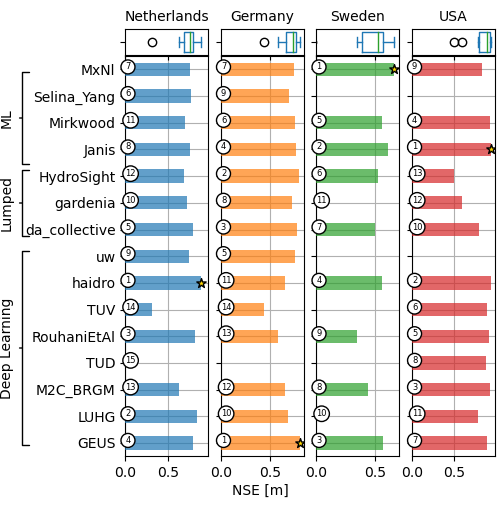

In [11]:
plot_metrics("nse", label="NSE [m]", best="max")
plt.savefig("../figures/figure_02.png", bbox_inches="tight", dpi=300)

### Figure 03: MAE

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_91344/4034549559.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


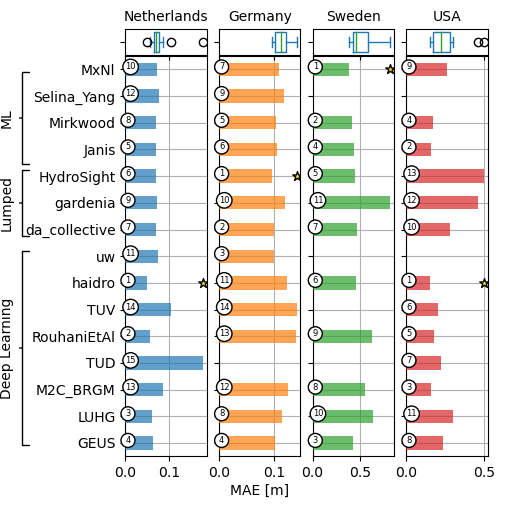

In [12]:
plot_metrics("mae", label="MAE [m]", best="min")
plt.savefig("../figures/figure_03.png", bbox_inches="tight", dpi=300)

### Figure 04 MAE_02

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_91344/4034549559.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


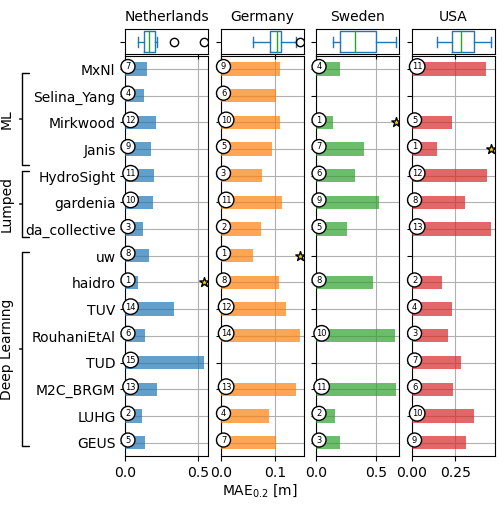

In [13]:
plot_metrics("mae_20", label="MAE$_{0.2}$ [m]", best="min")
plt.savefig("../figures/figure_04.png", bbox_inches="tight", dpi=300)

### Figure 05: MAE_0.8

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_91344/4034549559.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


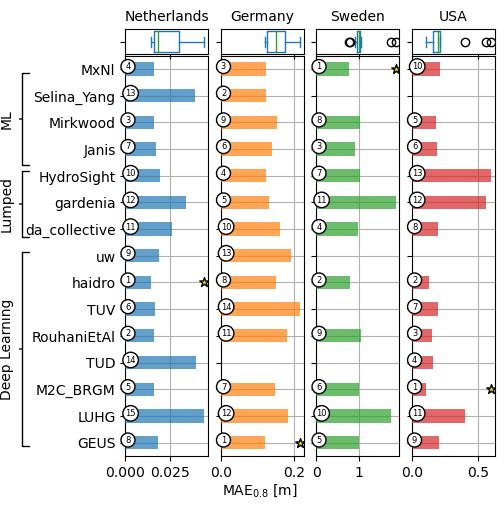

In [14]:
plot_metrics("mae_80", label="MAE$_{0.8}$ [m]", best="min")
plt.savefig("../figures/figure_05.png", bbox_inches="tight", dpi=300)

### Figure 6: PICP

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_91344/4034549559.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


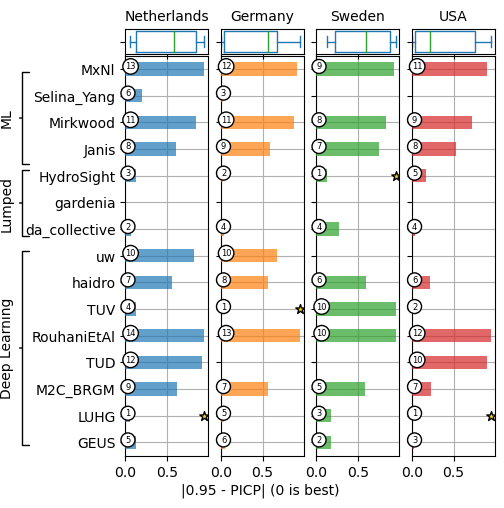

In [15]:
plot_metrics("PICP", label="|0.95 - PICP| (0 is best)", best="min")
plt.savefig("../figures/figure_06.png", bbox_inches="tight", dpi=300)

### Figure 07: Effort and time investment

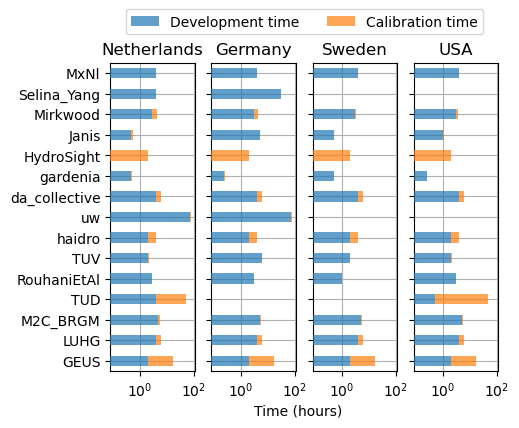

In [24]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.loc[:, (["Development time", "Calibration time"], slice(None))]
teams.head()

fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(5,4))

for ax, well in zip(axes, wells):
    teams.loc[order, (slice(None), well)].plot(kind="barh", zorder=10, ax=ax, legend=False, alpha=0.7, stacked=True, logx=True)
    ax.grid(which="major", ls="-")
    ax.set_title(well.split("_")[0])
    
fig.text(0.5, 0, 'Time (hours)', ha='center')
#axes[0].set_xlim(-0.01,1)1
plt.legend(["Development time", "Calibration time"], ncols=2,
           bbox_to_anchor=(-3.5,1.07), loc=3)

plt.savefig("../figures/figure_07.png", bbox_inches="tight", dpi=300)

### Figure 01. Head data in calibration and validation period

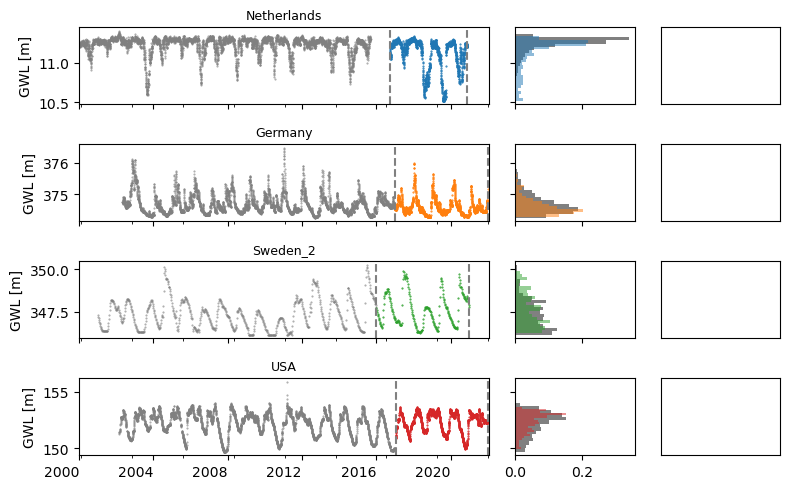

In [16]:
fig = plt.figure(figsize=(8,5))

gs = GridSpec(4, 5, figure=fig)

ts_axes = []
kde_axes = []
map_axes = []
ax = None

for i in range(4):
    if ax is None:
        ts_ax = fig.add_subplot(gs[i, 0:3])
        kde_ax = fig.add_subplot(gs[i, 3], sharey=ts_ax)

    else:
        ts_ax = fig.add_subplot(gs[i, 0:3], sharex=ts_axes[0])
        kde_ax = fig.add_subplot(gs[i, 3], sharey=ts_ax, sharex=kde_axes[0])
        
    ts_axes.append(ts_ax)
    kde_axes.append(kde_ax)
    
    ax = fig.add_subplot(gs[i, 4])
    map_axes.append(ax)
    ax.set_yticks([])
    ax.set_xticks([])

for i, (well, ax) in enumerate(zip(wells, ts_axes)):
    heads.loc[:tmin[well], well].plot(ax=ax, color="gray", marker=".", markersize=1, linestyle=" ", alpha=0.7)
    heads.loc[tmin[well]:tmax[well], well].plot(ax=ax, marker=".", markersize=1, linestyle=" ", color="C{}".format(i))
    ax.set_title(well, fontsize=9)
    ax.set_ylabel("GWL [m]")

    df = heads.loc[:tmin[well], well].dropna()
    df.hist(
        ax=kde_axes[i],
        orientation="horizontal",
        color="gray",
        bins=20,
        grid=False,
        alpha=1,
        weights = np.ones_like(df.values) / df.index.size
    )
    
    df = heads.loc[tmin[well]:tmax[well], well].dropna()
    df.hist(
        ax=kde_axes[i],
        orientation="horizontal",
        color="C{}".format(i),
        bins=20,
        grid=False,
        alpha=0.5,
        weights = np.ones_like(df.values) / df.index.size
    )

    ax.axvline(tmin[well], color="gray", linestyle="--")
    ax.axvline(tmax[well], color="gray", linestyle="--")    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

ax.set_xlim("2000", "2022-01-31")
plt.tight_layout()
plt.savefig("../figures/figure_01.png", bbox_inches="tight", dpi=300)

### Figure: PICP example

In [17]:
# well = "Sweden_2"
# head = heads.loc["2016":, well]
# head.index = head.index.round("D")
# bounds = sims.loc["2016":, ("da_collective", well, ["95% Lower Bound", "95% Upper Bound"])].dropna()
# sim = sims.loc["2016":, ("da_collective", well, ["Simulated Head"])].dropna()

# fig, ax = plt.subplots(1,1, figsize=(5,2))

# head.plot(x_compat=True, marker=".", linestyle=" ", color="k", markersize=1)
# obs_between = head.between(bounds.loc[head.index].iloc[:,0], bounds.loc[head.index].iloc[:,1])
# head.loc[~obs_between].plot(marker="x", color="r", linestyle=" ", markersize=2)
# ax.fill_between(bounds.index, bounds.iloc[:,0].values, bounds.iloc[:,1].values, 
#                 alpha=0.5)
# sim.plot(ax=ax, legend=False)

# plt.legend(["Heads Measured", "Heads outside PI", "95% Pred. Interval", "Simulated head"], fontsize=8, ncol=2)
# ax.set_ylabel("Head [m]")
# ax.set_xlabel("")
# for tick in ax.get_xticklabels():
#     tick.set_rotation(0)

# plt.savefig("../figures/picp_example.png", bbox_inches="tight", dpi=300)